In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models.scrambler_models_w_diff import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores


Using TensorFlow backend.


In [2]:
#Load tissue-specific model

import keras
import keras.backend as K
from keras.layers import Reshape, Concatenate, Lambda, Conv2D, BatchNormalization, Dense, Activation

def load_pas_network(n_cell_types=1) :

    conv_1 = Conv2D(16, (1, 8), padding='valid', activation='linear', name='pasnet_conv2d_1')
    batchnorm_1 = BatchNormalization(axis=-1, name='pasnet_batchnorm_1')
    relu_1 = Activation('relu')

    conv_2 = Conv2D(16, (1, 8), padding='valid', activation='linear', name='pasnet_conv2d_2')
    batchnorm_2 = BatchNormalization(axis=-1, name='pasnet_batchnorm_2')
    relu_2 = Activation('relu')

    max_pool_3 = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')

    def _net_func(sequence_input) :
        
        relu_1_out = relu_1(batchnorm_1(conv_1(sequence_input), training=False))
        relu_2_out = relu_2(batchnorm_2(conv_2(relu_1_out), training=False))

        max_pool_3_out = max_pool_3(relu_2_out)

        final_dense_out = final_dense(max_pool_3_out)
        
        return final_dense_out

    return _net_func

model_name = "human_convnet_16_16_no_dense_linear_leslie_hek293_testis_all_cuts_ensemble"

tissue_type = 'Testis'

n_bootstraps = 10

save_dir = '../../../../aparent/saved_models'

pas_models = []

for bootstrap_ix in range(n_bootstraps) :
    
    print("Loading model " + str(bootstrap_ix) + "...")
    
    pas_net = load_pas_network(
        n_cell_types=2
    )
    
    pas_input = Input(shape=(1, 205, 4), name='pas_input')
    
    pas_model = Model([pas_input], [pas_net(pas_input)])
    
    model_path = os.path.join(save_dir, model_name + '_' + str(bootstrap_ix) + '_pas_model' + '.h5')
    pas_model.load_weights(model_path, by_name=True)
    
    pas_models.append(pas_model)

ref_input = Input(name="ref_input", shape=(1, 205, 4))
var_input = Input(name="var_input", shape=(1, 205, 4))

ref_scores = Concatenate(axis=1)([Reshape((1, 2))(pas_models[bootstrap_ix](ref_input)) for bootstrap_ix in range(n_bootstraps)])
var_scores = Concatenate(axis=1)([Reshape((1, 2))(pas_models[bootstrap_ix](var_input)) for bootstrap_ix in range(n_bootstraps)])

mean_ref_scores = Lambda(lambda x: K.mean(x, axis=1))(ref_scores)
mean_var_scores = Lambda(lambda x: K.mean(x, axis=1))(var_scores)

dd_score = Lambda(lambda x: ((x[1][:, 1] - x[1][:, 0]) - (x[0][:, 1] - x[0][:, 0]))[:, None] )([mean_ref_scores, mean_var_scores])
#dd_score = Lambda(lambda x: (x[:, 1] - x[:, 0])[:, None] )(mean_var_scores)

predictor = Model([ref_input, var_input], [dd_score])

predictor.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


Loading model 0...
Loading model 1...
Loading model 2...
Loading model 3...
Loading model 4...
Loading model 5...
Loading model 6...
Loading model 7...
Loading model 8...
Loading model 9...


In [3]:

print(predictor.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ref_input (InputLayer)          (None, 1, 205, 4)    0                                            
__________________________________________________________________________________________________
var_input (InputLayer)          (None, 1, 205, 4)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2)            2754        ref_input[0][0]                  
                                                                 var_input[0][0]                  
__________________________________________________________________________________________________
model_2 (Model)                 (None, 2)            2754        ref_input[0][0]                  
          

In [4]:
#Load variant sequence selection

snp_pred_df = pd.read_csv("../../../../autoscrambler/analysis/apa/aparent_all_libs_resnet_no_clinvar_wt_ep_5_predictions_pred_df.csv", sep='\t')
snp_pred_df = snp_pred_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)

snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105
snp_pred_df['cut_to_snp'] = np.abs(snp_pred_df['snp_pos'] - 100)
snp_pred_df = snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

snp_pred_df = snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

snp_ids = [
    'chr19_49974386_C_A',
    'chr5_148383555_C_T',
    'chr10_53457124_G_A',
    'chr11_77925778_A_G',
    'chr4_186316829_A_G',
    'chr15_40328292_A_G',
]

df = snp_pred_df.set_index('snp_id').loc[snp_ids].reset_index()

df[['snp_id', 'gene', 'snp_pos', 'effect_size']]


,snp_id,gene,snp_pos,effect_size
0,chr19_49974386_C_A,ALDH16A1,86,-0.067592
1,chr5_148383555_C_T,SH3TC2,82,0.023033
2,chr10_53457124_G_A,CSTF2T,80,-0.021112
3,chr11_77925778_A_G,USP35,117,0.054378
4,chr4_186316829_A_G,UFSP2,98,0.036603
5,chr15_40328292_A_G,SRP14,82,0.018586


In [5]:
#Generate data feature matrices

#Load data matrices
encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

x_ref = np.concatenate([encoder(row['wide_seq_ext'][105:105+205])[None, None, ...] for _, row in df.iterrows()], axis=0)
x_var = np.concatenate([encoder(row['wide_seq_ext_var'][105:105+205])[None, None, ...] for _, row in df.iterrows()], axis=0)

b = np.max(x_ref - x_var, axis=-1)[..., None] * 50.


In [6]:
#Define sequence template and background

sequence_template = '$' * 205

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]


In [7]:
#Calculate biased, example-specific backgrounds

pseudo_count = 100.0

x_mean = np.ones((x_ref.shape[0], 205, 4)) * 0.25#(x_ref[:, 0, ...] + pseudo_count) / (1. + 4. * pseudo_count)

group = np.arange(x_mean.shape[0])[:, None]


In [8]:
#Run optimization with bias turned on across CSE, to reduce variance further

cse_bias = np.zeros((1, 1, 205, 1))
cse_bias[:, :, 70:76, :] = 50.


In [9]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 1,
    'n_resblocks_per_group' : 1,
    'n_channels' : 16,
    'window_size' : 3,
    'dilation_rates' : [1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    n_inputs=2,
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=205,
    n_out_channels=4,
    input_templates=[onehot_template for k in range(x_ref.shape[0])],
    input_backgrounds=[x_mean[0, :, :] for k in range(x_ref.shape[0])],
    batch_size=1,
    n_samples=128,
    multi_input_mode='shared',
    sample_mode='gumbel',
    gumbel_temp=0.1,
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config,
    subset_size=None
)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [10]:
#Round 1: Pre-training

[pwm_ref_pre, pwm_var_pre], [sample_ref_pre, sample_var_pre], [scores_pre, _], pretrain_histories = scrambler.optimize(
    predictor,
    [x_ref, x_var],
    np.zeros((x_ref.shape[0], 1)),
    bias=[b + np.tile(cse_bias, (x_ref.shape[0], 1, 1, 1))],
    group=[group, group],
    batch_size=1,
    n_iters=100,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='target',
    entropy_bits=0.5,
    entropy_weight=1.,
    subset_size=None,
    cache_prefix_path='saved_models/apa_vars_gtex',
    load_from_cache=False,
)

#Round 2: Fine-tuning

[pwm_ref_fine, pwm_var_fine], [sample_ref_fine, sample_var_fine], [scores_fine, _], finetune_histories = scrambler.optimize(
    predictor,
    [x_ref, x_var],
    np.zeros((x_ref.shape[0], 1)),
    bias=[b + np.tile(cse_bias, (x_ref.shape[0], 1, 1, 1))],
    group=[group, group],
    batch_size=1,
    n_iters=300,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='maximization',
    entropy_bits=0.0,
    entropy_weight=0.5,
    subset_size=None,
    cache_prefix_path='saved_models/apa_vars_gtex',
    load_from_cache=True,
)


Optimizing batch 0...
Epoch 1/1
100/100 [==============================] - 13s 128ms/step - loss: 2.5191e-04 - ft_nll_loss: 1.8001e-04 - ft_entropy_loss: 7.1907e-05
Epoch 1/1
100/100 [==============================] - 6s 60ms/step - loss: 3.2979e-04 - ft_nll_loss: 2.7254e-04 - ft_entropy_loss: 5.7251e-05
Epoch 1/1
100/100 [==============================] - 6s 59ms/step - loss: 3.2320e-04 - ft_nll_loss: 2.2447e-04 - ft_entropy_loss: 9.8728e-05
Epoch 1/1
100/100 [==============================] - 6s 60ms/step - loss: 4.4913e-04 - ft_nll_loss: 3.7506e-04 - ft_entropy_loss: 7.4070e-05
Epoch 1/1
100/100 [==============================] - 6s 60ms/step - loss: 4.7345e-04 - ft_nll_loss: 3.9911e-04 - ft_entropy_loss: 7.4335e-05
Epoch 1/1
100/100 [==============================] - 6s 61ms/step - loss: 3.2826e-04 - ft_nll_loss: 2.6061e-04 - ft_entropy_loss: 6.7653e-05
Optimizing batch 0...
Epoch 1/1
300/300 [==============================] - 21s 71ms/step - loss: 0.0934 - ft_nll_loss: 2.2333e-04 

In [11]:
#Cache interpretations

save_suffix = '_per_example_inference_mode_testis'

#Store interpretations
pickle.dump({
    'pwm_ref_pre' : pwm_ref_pre,
    'pwm_var_pre' : pwm_var_pre,

    'sample_ref_pre' : sample_ref_pre,
    'sample_var_pre' : sample_var_pre,
    
    'scores_pre' : scores_pre,
    
    'pwm_ref_fine' : pwm_ref_fine,
    'pwm_var_fine' : pwm_var_fine,

    'sample_ref_fine' : sample_ref_fine,
    'sample_var_fine' : sample_var_fine,

    'scores_fine' : scores_fine,
}, open('apaiants_gtex_interpretations' + save_suffix + '.pickle', 'wb'))

'''
#Load interpretations
cache_dict = pickle.load(open('apaiants_gtex_interpretations' + save_suffix + '.pickle', 'rb'))

pwm_ref_pre = cache_dict['pwm_ref_pre']
pwm_var_pre = cache_dict['pwm_var_pre']

sample_ref_pre = cache_dict['sample_ref_pre']
sample_var_pre = cache_dict['sample_var_pre']

scores_pre = cache_dict['scores_pre']

pwm_ref_fine = cache_dict['pwm_ref_fine']
pwm_var_fine = cache_dict['pwm_var_fine']

sample_ref_fine = cache_dict['sample_ref_fine']
sample_var_fine = cache_dict['sample_var_fine']

scores_fine = cache_dict['scores_fine']
'''

"\n#Load interpretations\ncache_dict = pickle.load(open('apaiants_gtex_interpretations' + save_suffix + '.pickle', 'rb'))\n\npwm_ref_pre = cache_dict['pwm_ref_pre']\npwm_var_pre = cache_dict['pwm_var_pre']\n\nsample_ref_pre = cache_dict['sample_ref_pre']\nsample_var_pre = cache_dict['sample_var_pre']\n\nscores_pre = cache_dict['scores_pre']\n\npwm_ref_fine = cache_dict['pwm_ref_fine']\npwm_var_fine = cache_dict['pwm_var_fine']\n\nsample_ref_fine = cache_dict['sample_ref_fine']\nsample_var_fine = cache_dict['sample_var_fine']\n\nscores_fine = cache_dict['scores_fine']\n"

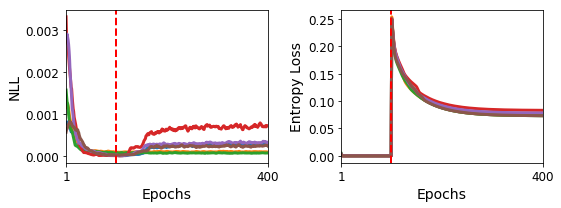

In [12]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(pretrain_histories[0]['ft_nll']) + len(finetune_histories[0]['ft_nll'])

n_epochs_pretrain = len(pretrain_histories[0]['ft_nll'])
n_epochs_finetune = len(finetune_histories[0]['ft_nll'])

nll_rolling_window = 5
entropy_rolling_window = 1

for i in range(len(pretrain_histories)) :
    ax1.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.concatenate([np.array(pretrain_histories[i]['ft_nll']), np.array(finetune_histories[i]['ft_nll'])], axis=0), window=nll_rolling_window), linewidth=3)

ax1.axvline(x=n_epochs_pretrain, linewidth=2, color='red', linestyle='--')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

for i in range(len(pretrain_histories)) :
    ax2.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.concatenate([np.array(pretrain_histories[i]['ft_entropy']), np.array(finetune_histories[i]['ft_entropy'])], axis=0), window=entropy_rolling_window), linewidth=3)

ax2.axvline(x=n_epochs_pretrain, linewidth=2, color='red', linestyle='--')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


Sequence 0:
 - Prediction (original) = 0.0306
 - Prediction (scrambled) = 0.0419


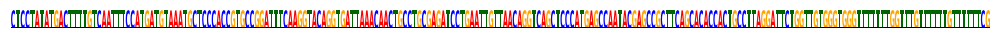

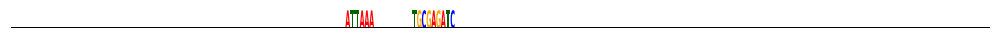

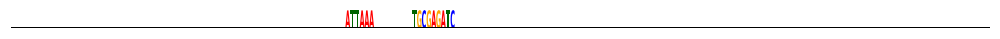

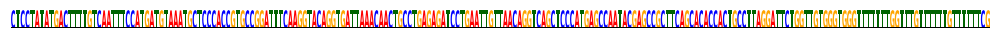

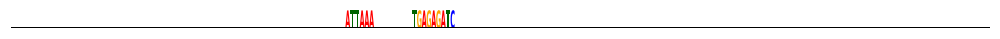

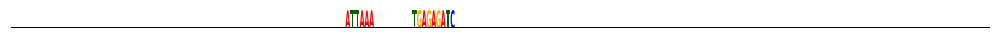

Sequence 1:
 - Prediction (original) = 0.0691
 - Prediction (scrambled) = 0.0639


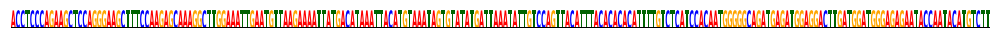

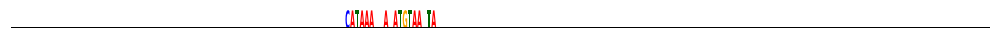

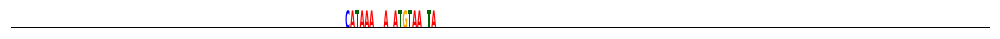

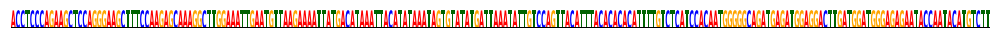

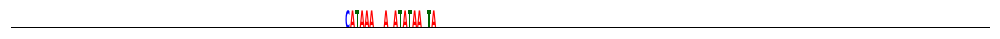

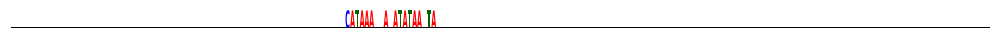

Sequence 2:
 - Prediction (original) = -0.144
 - Prediction (scrambled) = -0.146


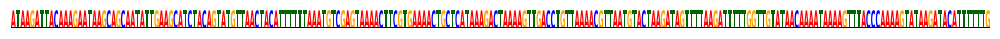

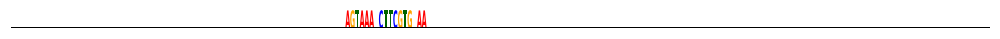

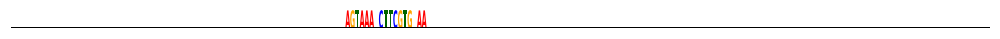

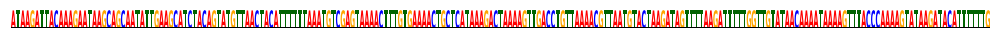

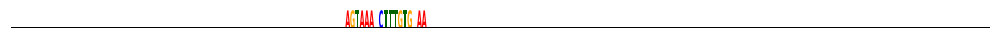

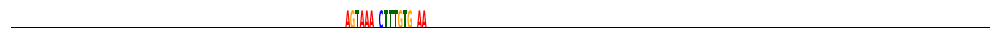

Sequence 3:
 - Prediction (original) = -0.185
 - Prediction (scrambled) = -0.160


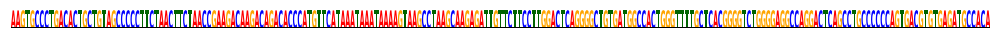

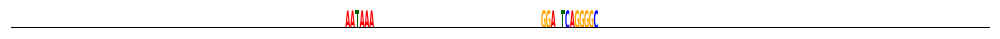

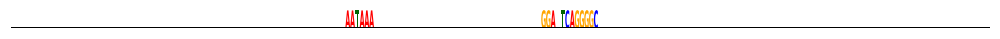

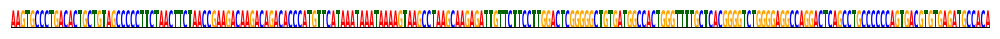

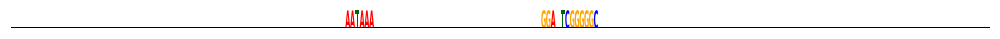

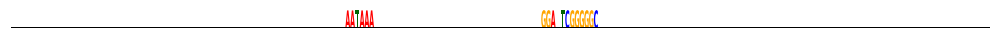

Sequence 4:
 - Prediction (original) = 0.1602
 - Prediction (scrambled) = 0.1727


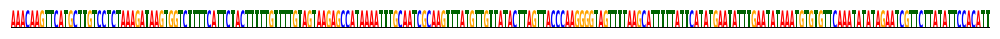

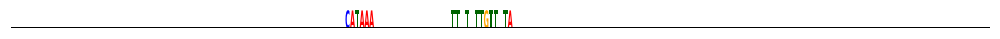

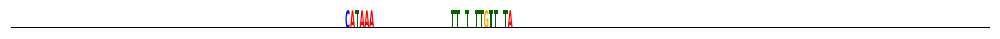

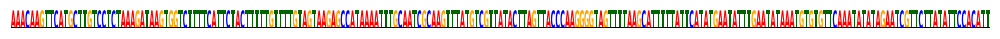

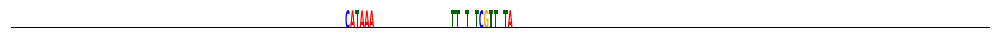

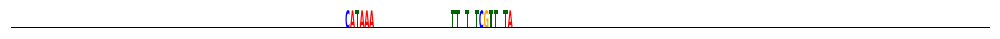

Sequence 5:
 - Prediction (original) = 0.0865
 - Prediction (scrambled) = 0.0923


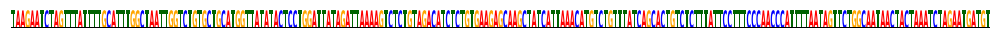

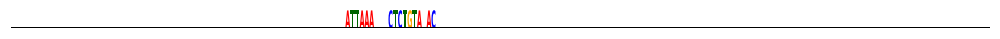

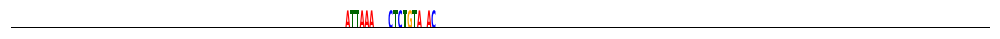

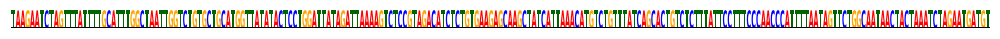

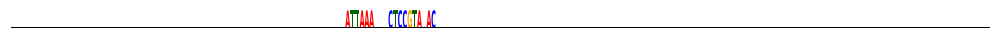

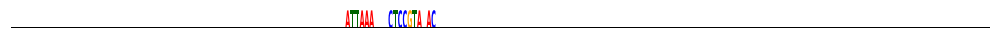

In [15]:
#Visualize a few reconstructed sequence patterns

model_name = "apa_vars_resnet_gtex_finetuned_testis"

pwm_ref_fine_no_bg = (2. * x_ref - 1.) * scores_fine * sequence_mask[None, None, :, None]
pwm_ref_fine_no_bg = np.exp(pwm_ref_fine_no_bg) / np.sum(np.exp(pwm_ref_fine_no_bg), axis=-1)[..., None]

pwm_var_fine_no_bg = (2. * x_var - 1.) * scores_fine * sequence_mask[None, None, :, None]
pwm_var_fine_no_bg = np.exp(pwm_var_fine_no_bg) / np.sum(np.exp(pwm_var_fine_no_bg), axis=-1)[..., None]

save_examples = [0, 1, 2, 3, 4, 5]

q_thresh = 0.95

for plot_i in range(x_ref.shape[0]) :
    
    print("Sequence " + str(plot_i) + ":")
    
    lor = predictor.predict(x=[x_ref[plot_i:plot_i+1], x_var[plot_i:plot_i+1]], batch_size=1)[0, 0]
    lor_scrambled_fine = np.mean(predictor.predict(x=[sample_ref_fine[plot_i], sample_var_fine[plot_i]], batch_size=32)[:, 0])
    
    print(" - Prediction (original) = " + str(round(lor, 6))[:6])
    print(" - Prediction (scrambled) = " + str(round(lor_scrambled_fine, 6))[:6])
    
    save_figs = False
    if save_examples is not None and plot_i in save_examples :
        save_figs = True
    
    score_clip = np.quantile(scores_fine[plot_i, 0, :, 0], q=q_thresh)
    
    plot_dna_logo(x_ref[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_ref")
    #plot_dna_logo(pwm_ref_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_ref" + "_pwm")
    plot_dna_logo(pwm_ref_fine_no_bg[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_ref" + "_pwm")
    plot_dna_importance_scores(scores_fine[plot_i, 0, :, :].T, encoder.decode(x_ref[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_ref" + "_scores")
    
    plot_dna_logo(x_var[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_var")
    #plot_dna_logo(pwm_var_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_var" + "_pwm")
    plot_dna_logo(pwm_var_fine_no_bg[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_var" + "_pwm")
    plot_dna_importance_scores(scores_fine[plot_i, 0, :, :].T, encoder.decode(x_var[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_var" + "_scores")
